In [41]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rc('figure', figsize=(8.0, 4.0), dpi=140)

In [42]:
snp_data = np.array([
37.88,-11.91,-28.48,-47.07,-15.15,46.59,-5.94,41.37,27.92,-38.59,
25.21,-5.45,-15.29,-17.86,12.43,19.45,13.80,30.72,-11.87,0.00,
-0.65,10.26,21.78,16.46,11.78,-6.62,45.02,26.40,2.62,-14.31,38.06,
8.48,-2.97,23.13,-11.81,18.89,12.97,9.06,-13.09,20.09,7.66,-11.36,
0.10,10.79,15.63,-17.37,-29.72,31.55,19.15,-11.50,1.06,12.31,25.77,
-9.73,14.76,17.27,1.40,26.33,14.62,2.03,12.40,27.25,-6.56,26.31,4.46,
7.06,-1.54,34.11,20.26,31.01,26.67,19.53,-10.14,-13.04,-23.37,26.38,
8.99,3.00,13.62,3.53,-38.49,23.45,12.78,0.00,13.41,29.60,11.39,-0.73,
9.54,19.42,-6.24,28.88,16.26,26.89,-19.44,24.23,23.31,16.39])


snp_year_count = len(snp_data) 
snp_mean_return = np.mean(snp_data)
snp_median_return = np.median(snp_data)
snp_years = np.arange(1928,1928 + snp_year_count)
assert len(snp_years) == snp_year_count
print(f'Number of years: {snp_year_count}')
print(f'Mean returns:    {snp_mean_return:.2f}%')
print(f'Median returns:  {snp_median_return:.2f}%')
print(f'First year: {snp_years[0]}, Last year: {snp_years[-1]}')
r = 1 + snp_data / 100.0
cagr = (r.prod()**(1/len(r)) - 1) * 100
print(f'CAGR:            {1 + cagr/100:.4f} ({cagr:.2f}%)')

Number of years: 98
Mean returns:    8.11%
Median returns:  11.59%
First year: 1928, Last year: 2025
CAGR:            1.0627 (6.27%)


In [43]:
#Normalize data to center around 1 -> -20% becomes 0.8, +30% becomes 1.3
snp_normal=(100+snp_data)/100
snp_normal_log = np.log(snp_normal)
snp_cagr=np.e**(np.sum(snp_normal_log)/snp_year_count)
print(f'CAGR returns:    {snp_cagr:.4f} ({(snp_cagr-1)*100:.2f}%)')
print(f'Starting wealth: 1')
print(f'Ending wealth over {snp_year_count} years: {snp_cagr**snp_year_count:.2f}')

#Or another way to compute it - cagr = geometric mean in this case 
product_of_returns = np.prod(snp_normal)
geometric_mean = product_of_returns**(1/snp_year_count)
print(f'Geometric mean (= CAGR): {geometric_mean:.4f} ({(geometric_mean-1)*100:.2f}%)')

CAGR returns:    1.0627 (6.27%)
Starting wealth: 1
Ending wealth over 98 years: 387.64
Geometric mean (= CAGR): 1.0627 (6.27%)


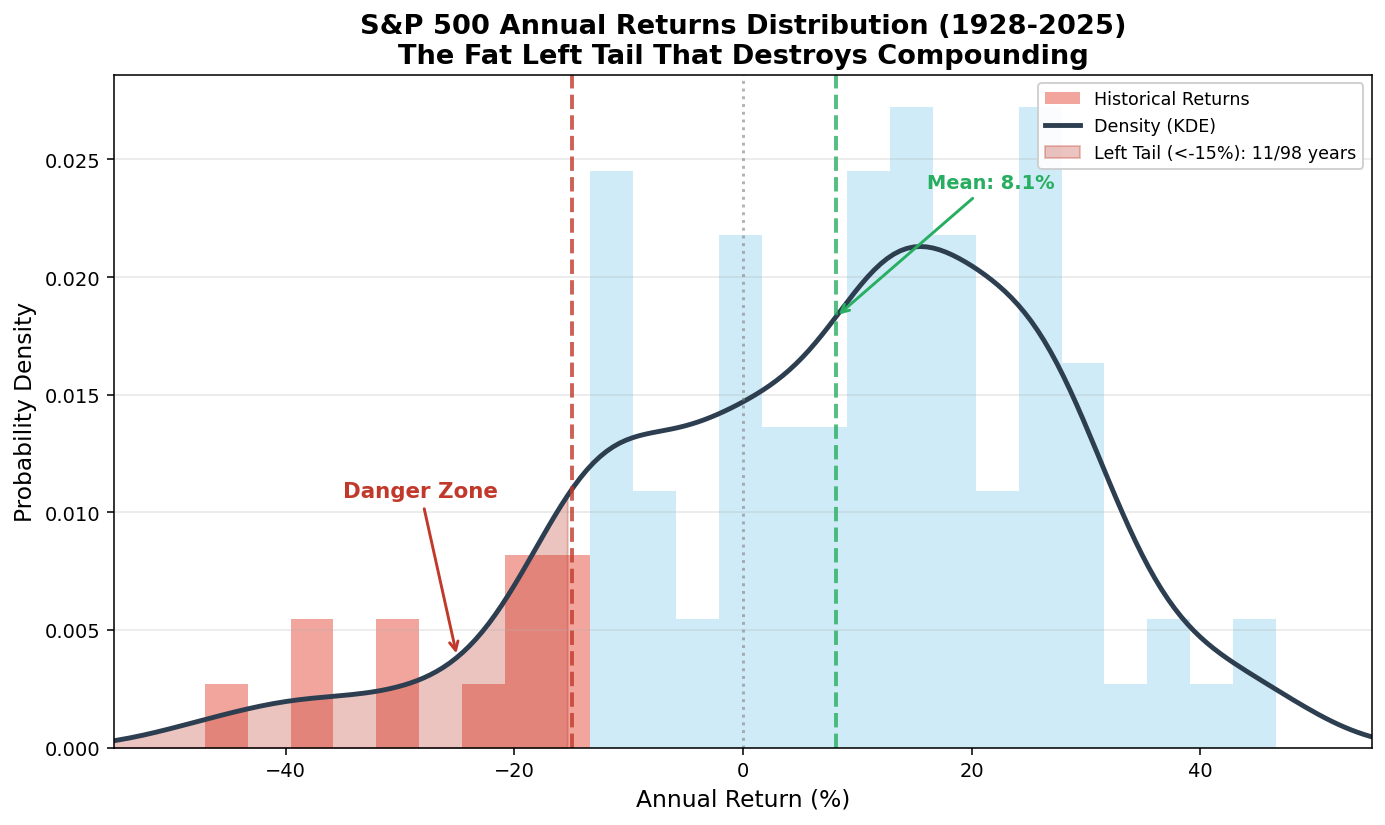

In [55]:
from scipy import stats

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

# Histogram with more bins for smoother appearance
n, bins_edges, patches = ax.hist(snp_data, bins=25, density=True, alpha=0.4, 
                                   color='skyblue', edgecolor='none',
                                   label='Historical Returns')

# Color the left tail bars red
for i, (patch, left_edge) in enumerate(zip(patches, bins_edges[:-1])):
    if left_edge < -15:
        patch.set_facecolor('#e74c3c')
        patch.set_alpha(0.5)

# KDE overlay
kde = stats.gaussian_kde(snp_data, bw_method=0.3)
x_range = np.linspace(snp_data.min() - 10, snp_data.max() + 10, 200)
kde_values = kde(x_range)

ax.plot(x_range, kde_values, color='#2c3e50', linewidth=2.5, label='Density (KDE)')

# Fill the left tail under KDE
tail_mask = x_range < -15
ax.fill_between(x_range[tail_mask], kde_values[tail_mask], 
                alpha=0.3, color='#c0392b', label=f'Left Tail (<-15%): {(snp_data < -15).sum()}/{len(snp_data)} years')

# Vertical lines for thresholds
ax.axvline(x=-15, color='#c0392b', linestyle='--', linewidth=2, alpha=0.8)
ax.axvline(x=0, color='gray', linestyle=':', linewidth=1.5, alpha=0.6)
ax.axvline(x=snp_mean_return, color='#27ae60', linestyle='--', linewidth=2, alpha=0.8)

# Labels
ax.set_xlabel('Annual Return (%)', fontsize=12)
ax.set_ylabel('Probability Density', fontsize=12)
ax.set_title('S&P 500 Annual Returns Distribution (1928-2025)\nThe Fat Left Tail That Destroys Compounding', 
             fontsize=14, fontweight='bold')

# Annotations
ax.annotate(f'Mean: {snp_mean_return:.1f}%', xy=(snp_mean_return, kde(snp_mean_return)[0]),
            xytext=(snp_mean_return + 8, kde(snp_mean_return)[0] * 1.3),
            fontsize=10, color='#27ae60', fontweight='bold',
            arrowprops=dict(arrowstyle='->', color='#27ae60', lw=1.5))

ax.annotate('Danger Zone', xy=(-25, kde(-25)[0]),
            xytext=(-35, kde_values.max() * 0.5),
            fontsize=11, color='#c0392b', fontweight='bold',
            arrowprops=dict(arrowstyle='->', color='#c0392b', lw=1.5))

# Legend
ax.legend(loc='upper right', fontsize=9, frameon=True, facecolor='white', framealpha=0.9)
ax.grid(True, alpha=0.3, axis='y')

# Set x limits
ax.set_xlim(-55, 55)

plt.tight_layout()
plt.show()

In [45]:
# Bootstrap (randomly draw with replacement) from the existing historical data. 
# We'll play the game 10,000 times over 25 years
trials=10000
years=25

sampled_snp_future_matrix_normal = np.random.choice(snp_normal, size=(trials, years), replace=True)
sampled_snp_future_matrix_normal_log= np.log(sampled_snp_future_matrix_normal)
sampled_cumulative_product_array_cagr_total_wealth_years = np.cumsum(sampled_snp_future_matrix_normal_log,axis=1)
cum_year_geom  = np.arange(1,1 + years)
cum_bev=np.e**(sampled_cumulative_product_array_cagr_total_wealth_years/cum_year_geom)
wealth_matrix = np.zeros((trials, years+1))
wealth_matrix[:, 0] = 1
# Calculate the wealth year by year
for year in range(1, years+1):
    wealth_matrix[:, year] = wealth_matrix[:, year - 1] * sampled_snp_future_matrix_normal[:, year-1]


## Verificatiom purposes only with previous block
sampled_cumulative_snp_future_matrix_cagr_total_years = sampled_cumulative_product_array_cagr_total_wealth_years[:,-1]
sampled_snp_future_matrix_bev=np.e**(sampled_cumulative_snp_future_matrix_cagr_total_years/years)
total_wealth = sampled_snp_future_matrix_bev**years
print('Starting wealth: 1')
print('Minimum ending wealth %6f vs maximum ending wealth %6f' % (np.min(total_wealth),np.max(total_wealth)))

Starting wealth: 1
Minimum ending wealth 0.039568 vs maximum ending wealth 138.911738


In [46]:
ending_wealth = wealth_matrix[:, 25]

# Calculate the 5th, 50th, and 95th percentiles for the ending wealth
percentiles = np.percentile(ending_wealth, [5, 50, 95])
mean = np.mean(ending_wealth)

# Find the indices of the trials that are closest to these percentiles
indices = [np.argmin(np.abs(ending_wealth - p)) for p in percentiles]
mean_indice =  [np.argmin(np.abs(ending_wealth - mean)) ]

arithmetic_avg= np.mean(sampled_snp_future_matrix_bev[mean_indice])

# Retrieve the entire series for those specific trials
series_5th_percentile = wealth_matrix[indices[0]]
series_50th_percentile = wealth_matrix[indices[1]]
series_95th_percentile = wealth_matrix[indices[2]]


print(f"Arithmetic mean CAGR:   {arithmetic_avg:.4f} ({(arithmetic_avg-1)*100:.2f}%)")
print(f"5th Percentile CAGR:    {sampled_snp_future_matrix_bev[indices[0]]:.4f} ({(sampled_snp_future_matrix_bev[indices[0]]-1)*100:.2f}%)")
print(f"50th Percentile CAGR:   {sampled_snp_future_matrix_bev[indices[1]]:.4f} ({(sampled_snp_future_matrix_bev[indices[1]]-1)*100:.2f}%)")
print(f"95th Percentile CAGR:   {sampled_snp_future_matrix_bev[indices[2]]:.4f} ({(sampled_snp_future_matrix_bev[indices[2]]-1)*100:.2f}%)")

Arithmetic mean CAGR:   1.0813 (8.13%)
5th Percentile CAGR:    0.9966 (-0.34%)
50th Percentile CAGR:   1.0639 (6.39%)
95th Percentile CAGR:   1.1302 (13.02%)


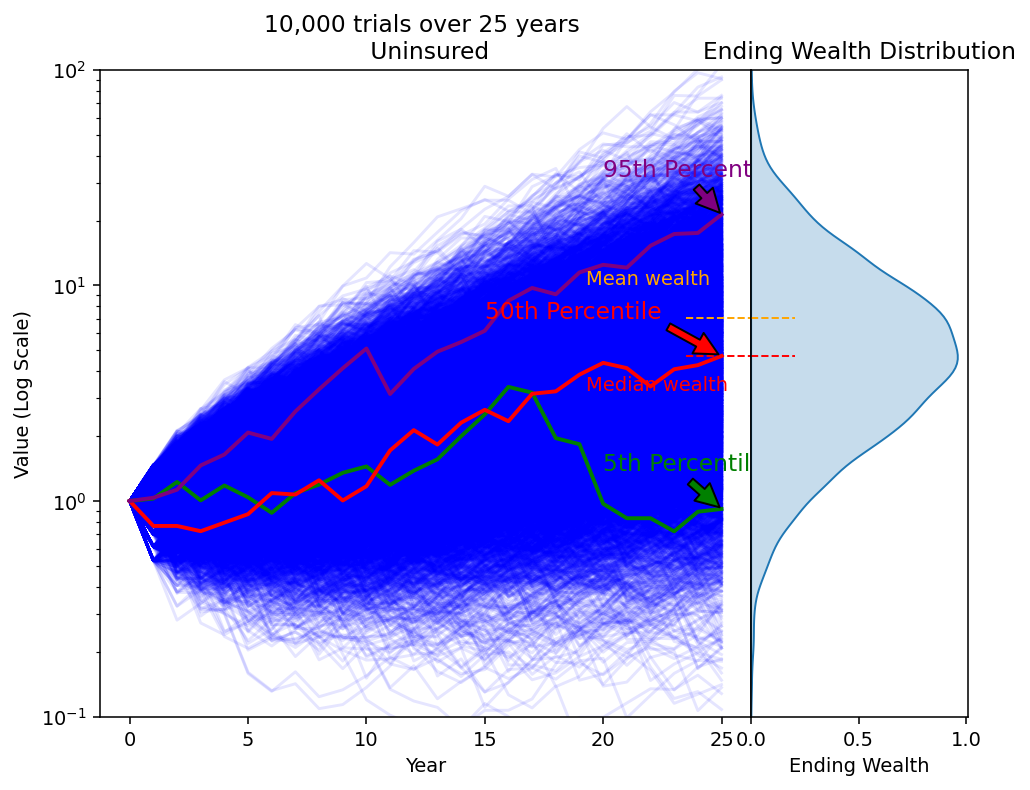

In [47]:
# Plot the 10,000 trials
fig, axs = plt.subplots(1, 2, figsize=(8, 6), gridspec_kw={'width_ratios': [3, 1],'wspace': 0.000})
ax = axs[0]
# Plot each row of the matrix as a line

for row in wealth_matrix[:10000]:
    ax.semilogy(row, alpha=0.1, color='blue')  # Adjust alpha for transparency

# Plot the 5th, 50th, and 95th percentile series with thicker lines
ax.semilogy(series_5th_percentile, color='green', linewidth=2, label='5th Percentile')
ax.semilogy(series_50th_percentile, color='red', linewidth=2, label='50th Percentile')
ax.semilogy(series_95th_percentile, color='purple', linewidth=2, label='95th Percentile')

# Set labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Value (Log Scale)')
ax.set_title('10,000 trials over 25 years \n Uninsured')

ax.annotate('5th Percentile', xy=(25, series_5th_percentile[-1]), xytext=(20, series_5th_percentile[-1]*1.5),
            arrowprops=dict(facecolor='green', shrink=0.05), fontsize=12, color='green')

ax.annotate('50th Percentile', xy=(25, series_50th_percentile[-1]), xytext=(15, series_50th_percentile[-1]*1.5),
            arrowprops=dict(facecolor='red', shrink=0.05), fontsize=12, color='red')

ax.annotate('95th Percentile', xy=(25, series_95th_percentile[-1]), xytext=(20, series_95th_percentile[-1]*1.5),
            arrowprops=dict(facecolor='purple', shrink=0.05), fontsize=12, color='purple')
ax.axhline(y=mean, color='orange', xmin= 0.9, linestyle='--', linewidth=1, label='Mean')
ax.axhline(y=series_50th_percentile[-1], color='red', xmin= 0.9, linestyle='--', linewidth=1, label='Median')
ax.annotate('Mean wealth',
            xy=(0, mean), xycoords=('axes fraction', 'data'),
            xytext=(250, 20), textcoords='offset points',
            color='orange', ha='left', va='center')

ax.annotate('Median wealth',
            xy=(0, series_50th_percentile[-1]), xycoords=('axes fraction', 'data'),
            xytext=(250, -15), textcoords='offset points',
            color='red', ha='left', va='center')

ax.set_ylim((0.1,100))



ax_density = axs[1]
sns.kdeplot(y=ending_wealth, ax=ax_density, fill=True,log_scale=True)
ax_density.set_title('Ending Wealth Distribution')
ax_density.set_xlabel('Ending Wealth')
ax_density.set_ylim((0.1,100))

ax_density.axhline(y=mean, color='orange', xmax= 0.2, linestyle='--', linewidth=1, label='Mean')
ax_density.axhline(y=series_50th_percentile[-1], color='red', xmax= 0.2, linestyle='--', linewidth=1, label='Median')
ax_density.yaxis.set_visible(False)
ax_density.tick_params(axis='y', which='both', left=False)

# Show the plot
plt.show()

In [48]:
# every year we invest 98% of the portfolio in the S&p500 and 2% in an insurance that delivers x15 if the market tanks 15% or more
# if the market is down by more than 15%, at the end of the year


# Define the condition where SPX falls below 85% (15% drop)
condition = sampled_snp_future_matrix_normal < 0.85

# Calculate the insurance payout (15 times the 2% investment)
insurance_payout = np.where(condition, 15 * 0.02, 0)

# Calculate the combined return
sampled_snp_future_matrix_normal_insured = (
    0.98 * sampled_snp_future_matrix_normal + insurance_payout
)



sampled_snp_future_matrix_normal_log_insured= np.log(sampled_snp_future_matrix_normal_insured)
sampled_cumulative_product_array_cagr_total_wealth_years_insured = np.cumsum(sampled_snp_future_matrix_normal_log_insured,axis=1)
cum_year_geom_insured  = np.arange(1,1 + years)
cum_bev_insured=np.e**(sampled_cumulative_product_array_cagr_total_wealth_years_insured/cum_year_geom_insured)
wealth_matrix_insured = np.zeros((trials, years+1))
wealth_matrix_insured[:, 0] = 1
# Calculate the wealth year by year
for year in range(1, years+1):
    wealth_matrix_insured[:, year] = wealth_matrix_insured[:, year - 1] * sampled_snp_future_matrix_normal_insured[:, year-1]



##verificatiom purposes only with previous block
sampled_cumulative_snp_future_matrix_cagr_total_years_insured = sampled_cumulative_product_array_cagr_total_wealth_years_insured[:,-1]
sampled_snp_future_matrix_bev_insured=np.e**(sampled_cumulative_snp_future_matrix_cagr_total_years_insured/years)
total_wealth_insured = sampled_snp_future_matrix_bev_insured**years

print('Uninsured minimum ending wealth %6f vs maximum ending wealth %6f' % (np.min(total_wealth),np.max(total_wealth)))
print('Insured minimum ending wealth %6f vs max ending wealth %6f' % (np.min(total_wealth_insured),np.max(total_wealth_insured)))

# Calculate statistics for UNINSURED portfolio
uninsured_mean = np.mean(total_wealth)
uninsured_median = np.median(total_wealth)
uninsured_5th = np.percentile(total_wealth, 5)
uninsured_95th = np.percentile(total_wealth, 95)
uninsured_min = np.min(total_wealth)
uninsured_max = np.max(total_wealth)

# Calculate statistics for INSURED portfolio
insured_mean = np.mean(total_wealth_insured)
insured_median = np.median(total_wealth_insured)
insured_5th = np.percentile(total_wealth_insured, 5)
insured_95th = np.percentile(total_wealth_insured, 95)
insured_min = np.min(total_wealth_insured)
insured_max = np.max(total_wealth_insured)

# Print results
print('=' * 70)
print('UNINSURED PORTFOLIO STATISTICS')
print('=' * 70)
print('Mean ending wealth:        %10.2f' % uninsured_mean)
print('Median ending wealth:      %10.2f' % uninsured_median)
print('5th percentile:            %10.2f' % uninsured_5th)
print('95th percentile:           %10.2f' % uninsured_95th)
print('Minimum ending wealth:     %10.2f' % uninsured_min)
print('Maximum ending wealth:     %10.2f' % uninsured_max)
print("")

print('INSURED PORTFOLIO STATISTICS')
print('=' * 70)
print('Mean ending wealth:        %10.2f' % insured_mean)
print('Median ending wealth:      %10.2f' % insured_median)
print('5th percentile:            %10.2f' % insured_5th)
print('95th percentile:           %10.2f' % insured_95th)
print('Minimum ending wealth:     %10.2f' % insured_min)
print('Maximum ending wealth:     %10.2f' % insured_max)


Uninsured minimum ending wealth 0.039568 vs maximum ending wealth 138.911738
Insured minimum ending wealth 0.621626 vs max ending wealth 83.828334
UNINSURED PORTFOLIO STATISTICS
Mean ending wealth:              7.07
Median ending wealth:            4.70
5th percentile:                  0.92
95th percentile:                21.32
Minimum ending wealth:           0.04
Maximum ending wealth:         138.91

INSURED PORTFOLIO STATISTICS
Mean ending wealth:              9.33
Median ending wealth:            7.43
5th percentile:                  2.50
95th percentile:                22.54
Minimum ending wealth:           0.62
Maximum ending wealth:          83.83


In [49]:
ending_wealth_insured = wealth_matrix_insured[:, 25]

# Calculate the 5th, 50th, and 95th percentiles for the ending wealth
percentiles_insured = np.percentile(ending_wealth_insured, [5, 50, 95])
mean_insured = np.mean(ending_wealth_insured)

# Find the indices of the trials that are closest to these percentiles
indices_insured = [np.argmin(np.abs(ending_wealth_insured - p)) for p in percentiles_insured]
mean_indice_insured =  [np.argmin(np.abs(ending_wealth_insured - mean_insured)) ]
# Retrieve the entire series for those specific trials
series_5th_percentile_insured = wealth_matrix_insured[indices_insured[0]]
series_50th_percentile_insured = wealth_matrix_insured[indices_insured[1]]
series_95th_percentile_insured = wealth_matrix_insured[indices_insured[2]]

arithmetic_avg_insured = np.mean(sampled_snp_future_matrix_normal_insured[indices_insured[1]])

print('=' * 70)
print('UNINSURED CAGR STATISTICS')
print('=' * 70)
print(f"Mean CAGR:            {arithmetic_avg:.4f} ({(arithmetic_avg-1)*100:.2f}%)")
print(f"Median CAGR:          {sampled_snp_future_matrix_bev[indices[1]]:.4f} ({(sampled_snp_future_matrix_bev[indices[1]]-1)*100:.2f}%)")
print(f"5th percentile CAGR:  {sampled_snp_future_matrix_bev[indices[0]]:.4f} ({(sampled_snp_future_matrix_bev[indices[0]]-1)*100:.2f}%)")
print(f"95th percentile CAGR: {sampled_snp_future_matrix_bev[indices[2]]:.4f} ({(sampled_snp_future_matrix_bev[indices[2]]-1)*100:.2f}%)")
print()
print('=' * 70)
print('INSURED CAGR STATISTICS (2% insurance, 15x payout at -15%)')
print('=' * 70)
print(f"Mean CAGR:            {arithmetic_avg_insured:.4f} ({(arithmetic_avg_insured-1)*100:.2f}%)")
print(f"Median CAGR:          {sampled_snp_future_matrix_bev_insured[indices_insured[1]]:.4f} ({(sampled_snp_future_matrix_bev_insured[indices_insured[1]]-1)*100:.2f}%)")
print(f"5th percentile CAGR:  {sampled_snp_future_matrix_bev_insured[indices_insured[0]]:.4f} ({(sampled_snp_future_matrix_bev_insured[indices_insured[0]]-1)*100:.2f}%)")
print(f"95th percentile CAGR: {sampled_snp_future_matrix_bev_insured[indices_insured[2]]:.4f} ({(sampled_snp_future_matrix_bev_insured[indices_insured[2]]-1)*100:.2f}%)")

UNINSURED CAGR STATISTICS
Mean CAGR:            1.0813 (8.13%)
Median CAGR:          1.0639 (6.39%)
5th percentile CAGR:  0.9966 (-0.34%)
95th percentile CAGR: 1.1302 (13.02%)

INSURED CAGR STATISTICS (2% insurance, 15x payout at -15%)
Mean CAGR:            1.0951 (9.51%)
Median CAGR:          1.0835 (8.35%)
5th percentile CAGR:  1.0373 (3.73%)
95th percentile CAGR: 1.1327 (13.27%)


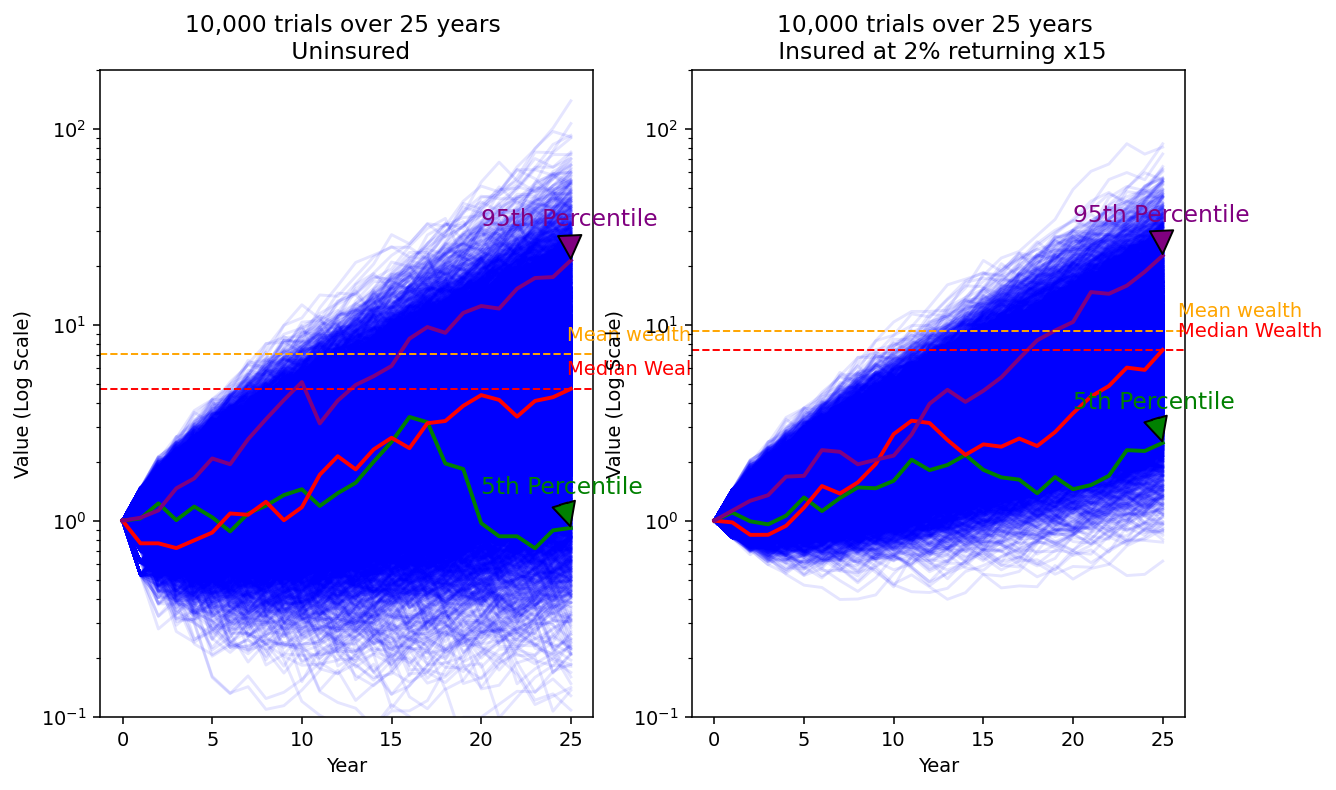

In [50]:
fig3, axs3 = plt.subplots(1, 2, figsize=(10, 6), gridspec_kw={'width_ratios': [1, 1],'wspace': 0.2})

ax=axs3[0]

for row in wealth_matrix[:10000]:
    ax.semilogy(row, alpha=0.1, color='blue')  # Adjust alpha for transparency

# Plot the 5th, 50th, and 95th percentile series with thicker lines
ax.semilogy(series_5th_percentile, color='green', linewidth=2, label='5th Percentile')
ax.semilogy(series_50th_percentile, color='red', linewidth=2, label='50th Percentile')
ax.semilogy(series_95th_percentile, color='purple', linewidth=2, label='95th Percentile')

# Set labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Value (Log Scale)')
ax.set_title('10,000 trials over 25 years \n Uninsured')

ax.annotate('5th Percentile', xy=(25, series_5th_percentile[-1]), xytext=(20, series_5th_percentile[-1]*1.5),
            arrowprops=dict(facecolor='green', shrink=0.05), fontsize=12, color='green')
# ax.annotate('50th Percentile', xy=(25, series_50th_percentile[-1]), xytext=(20, series_50th_percentile[-1]*1.5),
#             arrowprops=dict(facecolor='red', shrink=0.05), fontsize=12, color='red')
# ax.annotate('Mean', xy=(25, mean), xytext=(20, mean*1.5),
#             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, color='black')
ax.annotate('95th Percentile', xy=(25, series_95th_percentile[-1]), xytext=(20, series_95th_percentile[-1]*1.5),
            arrowprops=dict(facecolor='purple', shrink=0.05), fontsize=12, color='purple')
# ax.annotate('Value for the 120 years', xy=(25, snp_cagr**years), xytext=(23, (snp_cagr**years)*1.5),
#             arrowprops=dict(facecolor='blue', shrink=0.05), fontsize=12, color='blue')

ax.axhline(y=mean, color='orange', xmin= 0.0, linestyle='--', linewidth=1, label='Mean')
ax.axhline(y=series_50th_percentile[-1], color='red', xmin= 0.0, linestyle='--', linewidth=1, label='Median')

ax.annotate('Mean wealth', xy=(0, mean), xycoords=('axes fraction', 'data'),
                xytext=(240, 10), textcoords='offset points', color='orange',
                ha='left', va='center')

ax.annotate('Median Wealth', xy=(0, series_50th_percentile[-1]), xycoords=('axes fraction', 'data'),
                xytext=(240, 10), textcoords='offset points', color='red',
                ha='left', va='center')

ax.set_ylim((0.1,200))


ax_ins = axs3[1]
# Plot each row of the matrix as a line

for row in wealth_matrix_insured[:10000]:
    ax_ins.semilogy(row, alpha=0.1, color='blue')  # Adjust alpha for transparency

# Plot the 5th, 50th, and 95th percentile series with thicker lines
ax_ins.semilogy(series_5th_percentile_insured, color='green', linewidth=2, label='5th Percentile')
ax_ins.semilogy(series_50th_percentile_insured, color='red', linewidth=2, label='50th Percentile')
ax_ins.semilogy(series_95th_percentile_insured, color='purple', linewidth=2, label='95th Percentile')

# Set labels and title
ax_ins.set_xlabel('Year')
ax_ins.set_ylabel('Value (Log Scale)')
ax_ins.set_title('10,000 trials over 25 years \n Insured at 2% returning x15')

ax_ins.annotate('5th Percentile', xy=(25, series_5th_percentile_insured[-1]), xytext=(20, series_5th_percentile_insured[-1]*1.5),
            arrowprops=dict(facecolor='green', shrink=0.05), fontsize=12, color='green')
# ax_ins.annotate('50th Percentile', xy=(25, series_50th_percentile_insured[-1]), xytext=(20, series_50th_percentile_insured[-1]*1.5),
#             arrowprops=dict(facecolor='red', shrink=0.05), fontsize=12, color='red')
# ax_ins.annotate('Mean', xy=(25, mean_insured), xytext=(20, mean_insured*1.5),
#             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, color='black')
ax_ins.annotate('95th Percentile', xy=(25, series_95th_percentile_insured[-1]), xytext=(20, series_95th_percentile_insured[-1]*1.5),
            arrowprops=dict(facecolor='purple', shrink=0.05), fontsize=12, color='purple')
# ax_ins.annotate('Value for the 120 years', xy=(25, snp_cagr**years), xytext=(23, (snp_cagr**years)*1.5),
#             arrowprops=dict(facecolor='blue', shrink=0.05), fontsize=12, color='blue')

ax_ins.axhline(y=mean_insured, color='orange', xmin= 0.0, linestyle='--', linewidth=1, label='Mean')
ax_ins.axhline(y=series_50th_percentile_insured[-1], color='red', xmin= 0.0, linestyle='--', linewidth=1, label='Median')

ax_ins.annotate('Mean wealth', xy=(0, mean_insured), xycoords=('axes fraction', 'data'),
                xytext=(250, 10), textcoords='offset points', color='orange',
                ha='left', va='center')

ax_ins.annotate('Median Wealth', xy=(0, series_50th_percentile_insured[-1]), xycoords=('axes fraction', 'data'),
                xytext=(250, 10), textcoords='offset points', color='red',
                ha='left', va='center')

ax_ins.set_ylim((0.1,200))


plt.show()

In [51]:
thresholds = np.array([0.60, 0.65, 0.70, 0.75, 0.80, 0.85])
#                      -40%  -35%  -30%  -25%  -20%  -15%

insurances = np.array([0.01, 0.02, 0.025, 0.03, 0.04, 0.05])

insurance_multiplier_when_threshold_met = np.array([
    75,   # 
    50,   # 
    25,   # 
    18,   # 
    12,   # 
    7     #
])

# Initialize storage for results
results = []

# Iterate over each threshold and insurance combination
for i,threshold in enumerate(thresholds):
    for insurance in insurances:
        payout = np.where(
            sampled_snp_future_matrix_normal < threshold,
            insurance_multiplier_when_threshold_met[i] * insurance,
            0.0
        )

        sampled_snp_future_matrix_normal_insured = (
            (1 - insurance) * sampled_snp_future_matrix_normal + payout
        )

        # Calculate the log of the insured matrix
        sampled_snp_future_matrix_normal_log_insured = np.log(sampled_snp_future_matrix_normal_insured)

        # Calculate the cumulative product array
        sampled_cumulative_product_array_cagr_total_wealth_years_insured = np.cumsum(sampled_snp_future_matrix_normal_log_insured, axis=1)

        # Initialize the wealth matrix
        wealth_matrix_insured = np.zeros((trials, years + 1))
        wealth_matrix_insured[:, 0] = 1

        # Calculate the wealth year by year
        for year in range(1, years + 1):
            wealth_matrix_insured[:, year] = wealth_matrix_insured[:, year - 1] * sampled_snp_future_matrix_normal_insured[:, year - 1]

        # For verification purposes
        sampled_cumulative_snp_future_matrix_cagr_total_years_insured = sampled_cumulative_product_array_cagr_total_wealth_years_insured[:, -1]
        sampled_snp_future_matrix_bev_insured = np.e**(sampled_cumulative_snp_future_matrix_cagr_total_years_insured / years)
        total_wealth_insured = sampled_snp_future_matrix_bev_insured**years

        ending_wealth = wealth_matrix_insured[:, 25]
        percentiles = np.percentile(ending_wealth, [5, 50, 95])
        indices = [np.argmin(np.abs(ending_wealth - p)) for p in percentiles]
        
        # Store the results
        results.append({
            "threshold": threshold,
            "insurance": insurance,
            "insurance_multiplier_when_threshold_met": insurance_multiplier_when_threshold_met[i],
            "wealth_matrix_insured": wealth_matrix_insured,
            "total_wealth_insured": total_wealth_insured * wealth_matrix_insured[:, 0] ,
            "min_wealth": np.min(total_wealth_insured*  wealth_matrix_insured[:, 0]),
            "median_wealth": np.median(total_wealth_insured*  wealth_matrix_insured[:, 0]),
            "max_wealth": np.max(total_wealth_insured*  wealth_matrix_insured[:, 0]),
            "5th_percentile_cagr": sampled_snp_future_matrix_bev_insured[indices[0]],
            "50th_percentile_cagr": sampled_snp_future_matrix_bev_insured[indices[1]],
            "95th_percentile_cagr": sampled_snp_future_matrix_bev_insured[indices[2]]
        })

# Color coding function
def get_color(value):
    """
    Returns ANSI color code based on value.
    Positive = Green, Negative = Red
    """
    STRONG_RED = '\033[91m'      # Bright red (severe negative)
    LIGHT_RED = '\033[31m'       # Red (negative)
    LIGHT_GREEN = '\033[32m'     # Green (positive)
    STRONG_GREEN = '\033[92m'    # Bright green (strong positive)
    
    if value < -1.0:
        return STRONG_RED
    elif value < 0:
        return LIGHT_RED
    elif value <= 1.0:
        return LIGHT_GREEN
    else:
        return STRONG_GREEN

def colored(text, value):
    """Wrap text with color based on value"""
    RESET = '\033[0m'
    return f"{get_color(value)}{text}{RESET}"

# Print header once
print('=' * 80)
print(' SAFE HAVEN ANALYSIS: INSURED vs UNINSURED PORTFOLIO COMPARISON '.center(80))
print('=' * 80)
print()

# Calculate uninsured CAGR percentiles (baseline)
ending_wealth_unins = wealth_matrix[:, 25]
percentiles_unins = np.percentile(ending_wealth_unins, [5, 50, 95])
indices_unins = [np.argmin(np.abs(ending_wealth_unins - p)) for p in percentiles_unins]
cagr_5_unins = sampled_snp_future_matrix_bev[indices_unins[0]]
cagr_50_unins = sampled_snp_future_matrix_bev[indices_unins[1]]
cagr_95_unins = sampled_snp_future_matrix_bev[indices_unins[2]]

# Uninsured baseline
print('-' * 80)
print(' BASELINE: 100% S&P 500 (Uninsured)')
print('-' * 80)
print(f'  Wealth   ->  Min: {np.min(total_wealth):>10.2f}   Median: {np.median(total_wealth):>10.2f}   Max: {np.max(total_wealth):>10.2f}')
print(f'  CAGR     ->  5th: {cagr_5_unins:.4f} ({(cagr_5_unins-1)*100:>+.2f}%)   50th: {cagr_50_unins:.4f} ({(cagr_50_unins-1)*100:>+.2f}%)   95th: {cagr_95_unins:.4f} ({(cagr_95_unins-1)*100:>+.2f}%)')
print('=' * 80)
print()

# Results for each configuration
for result in results:
    threshold_pct = (1 - result['threshold']) * 100
    ins_pct = result['insurance'] * 100
    mult = result['insurance_multiplier_when_threshold_met']
    
    cagr_5 = result['5th_percentile_cagr']
    cagr_50 = result['50th_percentile_cagr']
    cagr_95 = result['95th_percentile_cagr']
    
    # Deltas
    delta_min = result['min_wealth'] - np.min(total_wealth)
    delta_med = result['median_wealth'] - np.median(total_wealth)
    delta_max = result['max_wealth'] - np.max(total_wealth)
    delta_cagr_5 = (cagr_5 - cagr_5_unins) * 100
    delta_cagr_50 = (cagr_50 - cagr_50_unins) * 100
    delta_cagr_95 = (cagr_95 - cagr_95_unins) * 100
    
    # Delta in percentage points
    delta_pct_5 = (cagr_5 - 1) * 100 - (cagr_5_unins - 1) * 100
    delta_pct_50 = (cagr_50 - 1) * 100 - (cagr_50_unins - 1) * 100
    delta_pct_95 = (cagr_95 - 1) * 100 - (cagr_95_unins - 1) * 100
    
    print('-' * 80)
    print(f' INSURED: {ins_pct:.1f}% allocation | Trigger: -{threshold_pct:.0f}% drop | Payout: x{mult}')
    print('-' * 80)
    print()
    print(f'  {"WEALTH":<18} {"Insured":>12} {"Uninsured":>12} {"Delta":>12}')
    print(f'  {"-"*18} {"-"*12} {"-"*12} {"-"*12}')
    print(f'  {"Minimum":<18} {result["min_wealth"]:>12.2f} {np.min(total_wealth):>12.2f} {colored(f"{delta_min:>+12.2f}", delta_min)}')
    print(f'  {"Median":<18} {result["median_wealth"]:>12.2f} {np.median(total_wealth):>12.2f} {colored(f"{delta_med:>+12.2f}", delta_med)}')
    print(f'  {"Maximum":<18} {result["max_wealth"]:>12.2f} {np.max(total_wealth):>12.2f} {colored(f"{delta_max:>+12.2f}", delta_max)}')
    print()
    print(f'  {"CAGR":<18} {"Insured":>12} {"Uninsured":>12} {"Delta (bps)":>12}')
    print(f'  {"-"*18} {"-"*12} {"-"*12} {"-"*12}')
    print(f'  {"5th Percentile":<18} {colored(f"{cagr_5:>12.4f}", delta_pct_5)} {cagr_5_unins:>12.4f} {colored(f"{delta_cagr_5*100:>+12.0f}", delta_pct_5)}')
    print(f'  {"50th Percentile":<18} {colored(f"{cagr_50:>12.4f}", delta_pct_50)} {cagr_50_unins:>12.4f} {colored(f"{delta_cagr_50*100:>+12.0f}", delta_pct_50)}')
    print(f'  {"95th Percentile":<18} {colored(f"{cagr_95:>12.4f}", delta_pct_95)} {cagr_95_unins:>12.4f} {colored(f"{delta_cagr_95*100:>+12.0f}", delta_pct_95)}')
    print()
    print(f'  {"(CAGR as %)":<18} {"Insured":>12} {"Uninsured":>12} {"Delta (pp)":>12}')
    print(f'  {"-"*18} {"-"*12} {"-"*12} {"-"*12}')
    print(f'  {"5th Percentile":<18} {colored(f"{(cagr_5-1)*100:>+11.2f}%", delta_pct_5)} {(cagr_5_unins-1)*100:>+11.2f}% {colored(f"{delta_pct_5:>+11.2f}pp", delta_pct_5)}')
    print(f'  {"50th Percentile":<18} {colored(f"{(cagr_50-1)*100:>+11.2f}%", delta_pct_50)} {(cagr_50_unins-1)*100:>+11.2f}% {colored(f"{delta_pct_50:>+11.2f}pp", delta_pct_50)}')
    print(f'  {"95th Percentile":<18} {colored(f"{(cagr_95-1)*100:>+11.2f}%", delta_pct_95)} {(cagr_95_unins-1)*100:>+11.2f}% {colored(f"{delta_pct_95:>+11.2f}pp", delta_pct_95)}')
    print()

         SAFE HAVEN ANALYSIS: INSURED vs UNINSURED PORTFOLIO COMPARISON         

--------------------------------------------------------------------------------
 BASELINE: 100% S&P 500 (Uninsured)
--------------------------------------------------------------------------------
  Wealth   ->  Min:       0.04   Median:       4.70   Max:     138.91
  CAGR     ->  5th: 0.9966 (-0.34%)   50th: 1.0639 (+6.39%)   95th: 1.1302 (+13.02%)

--------------------------------------------------------------------------------
 INSURED: 1.0% allocation | Trigger: -40% drop | Payout: x75
--------------------------------------------------------------------------------

  WEALTH                  Insured    Uninsured        Delta
  ------------------ ------------ ------------ ------------
  Minimum                    0.10         0.04        +0.06
  Median                     4.58         4.70        -0.12
  Maximum                  109.45       138.91       -29.47

  CAGR                    Insured    Un

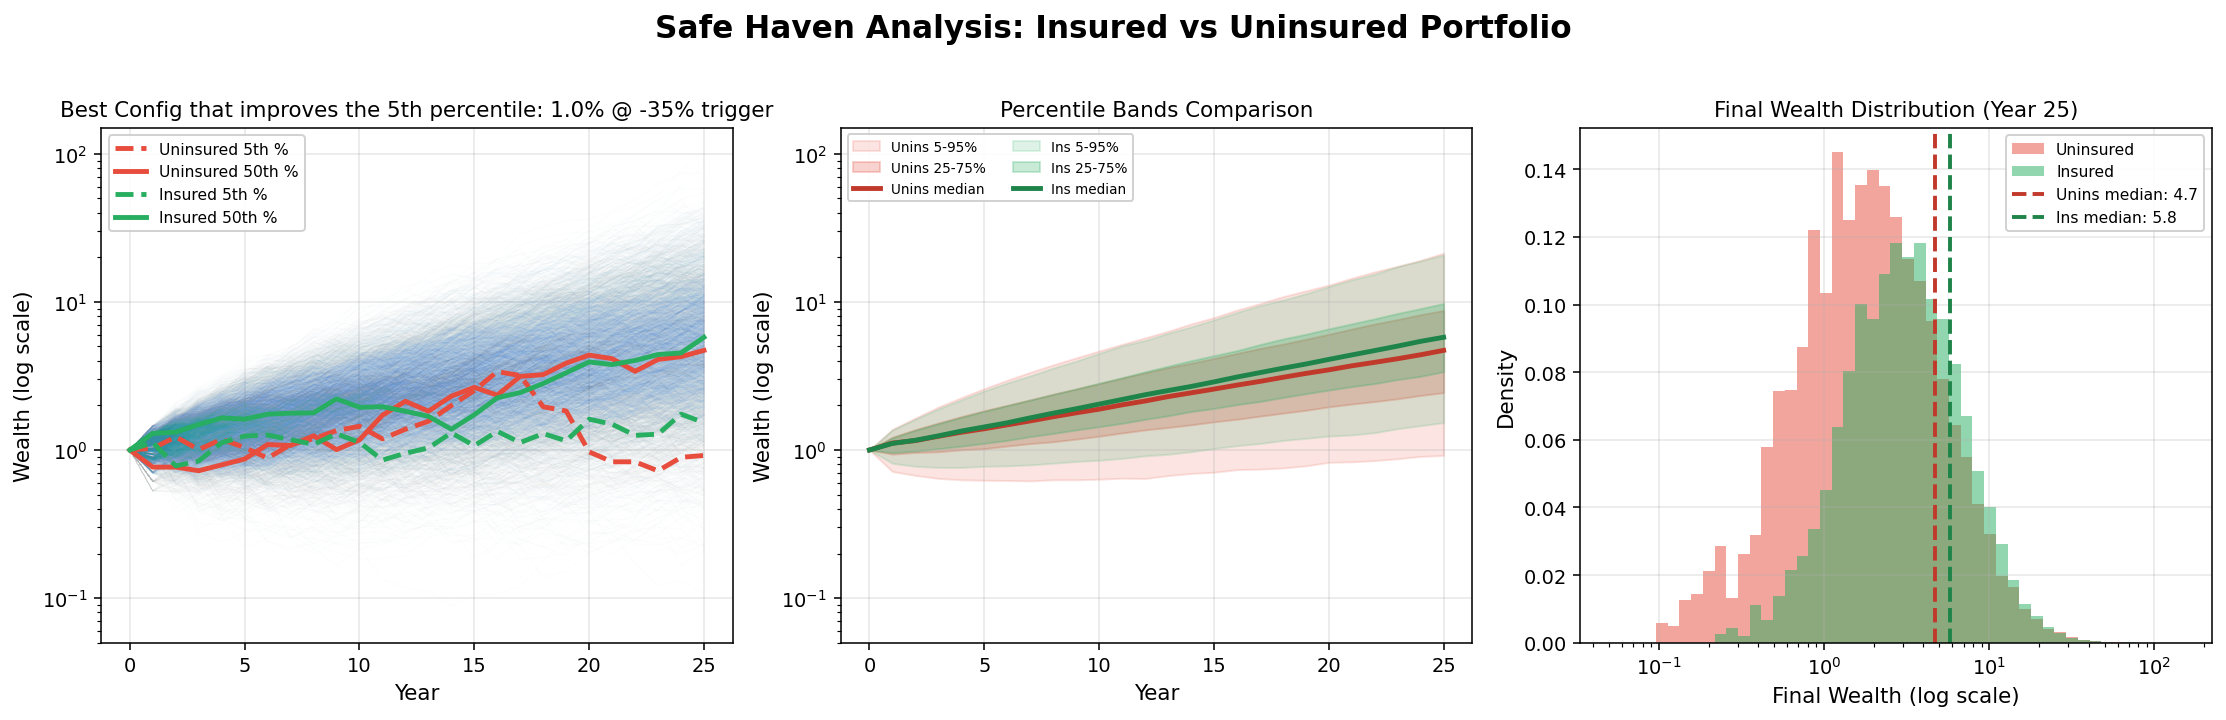

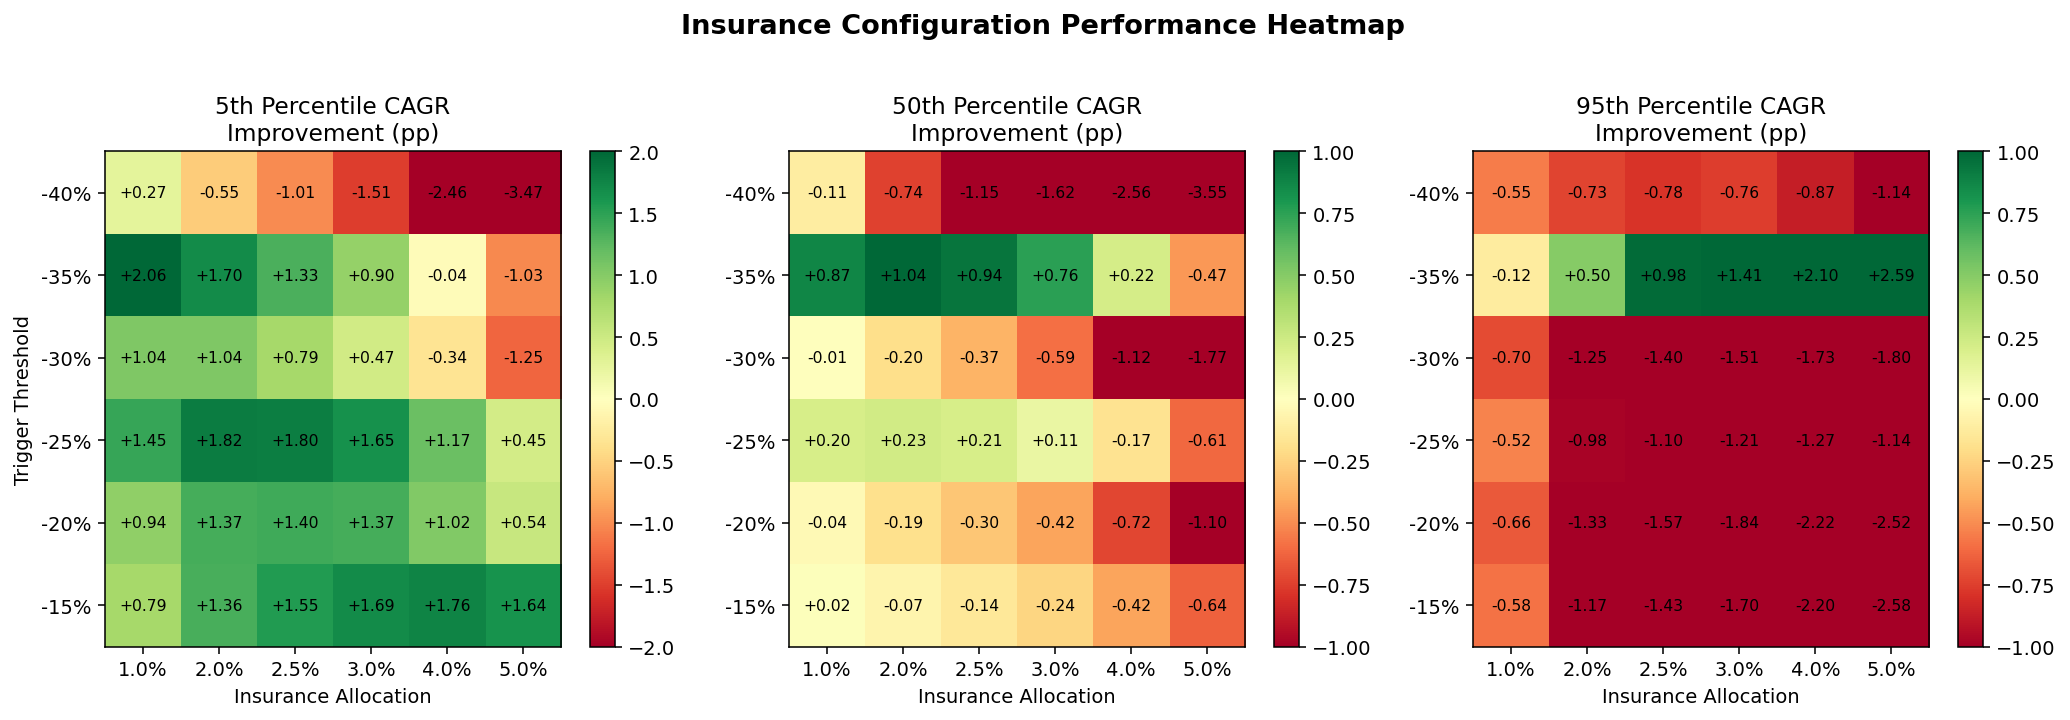

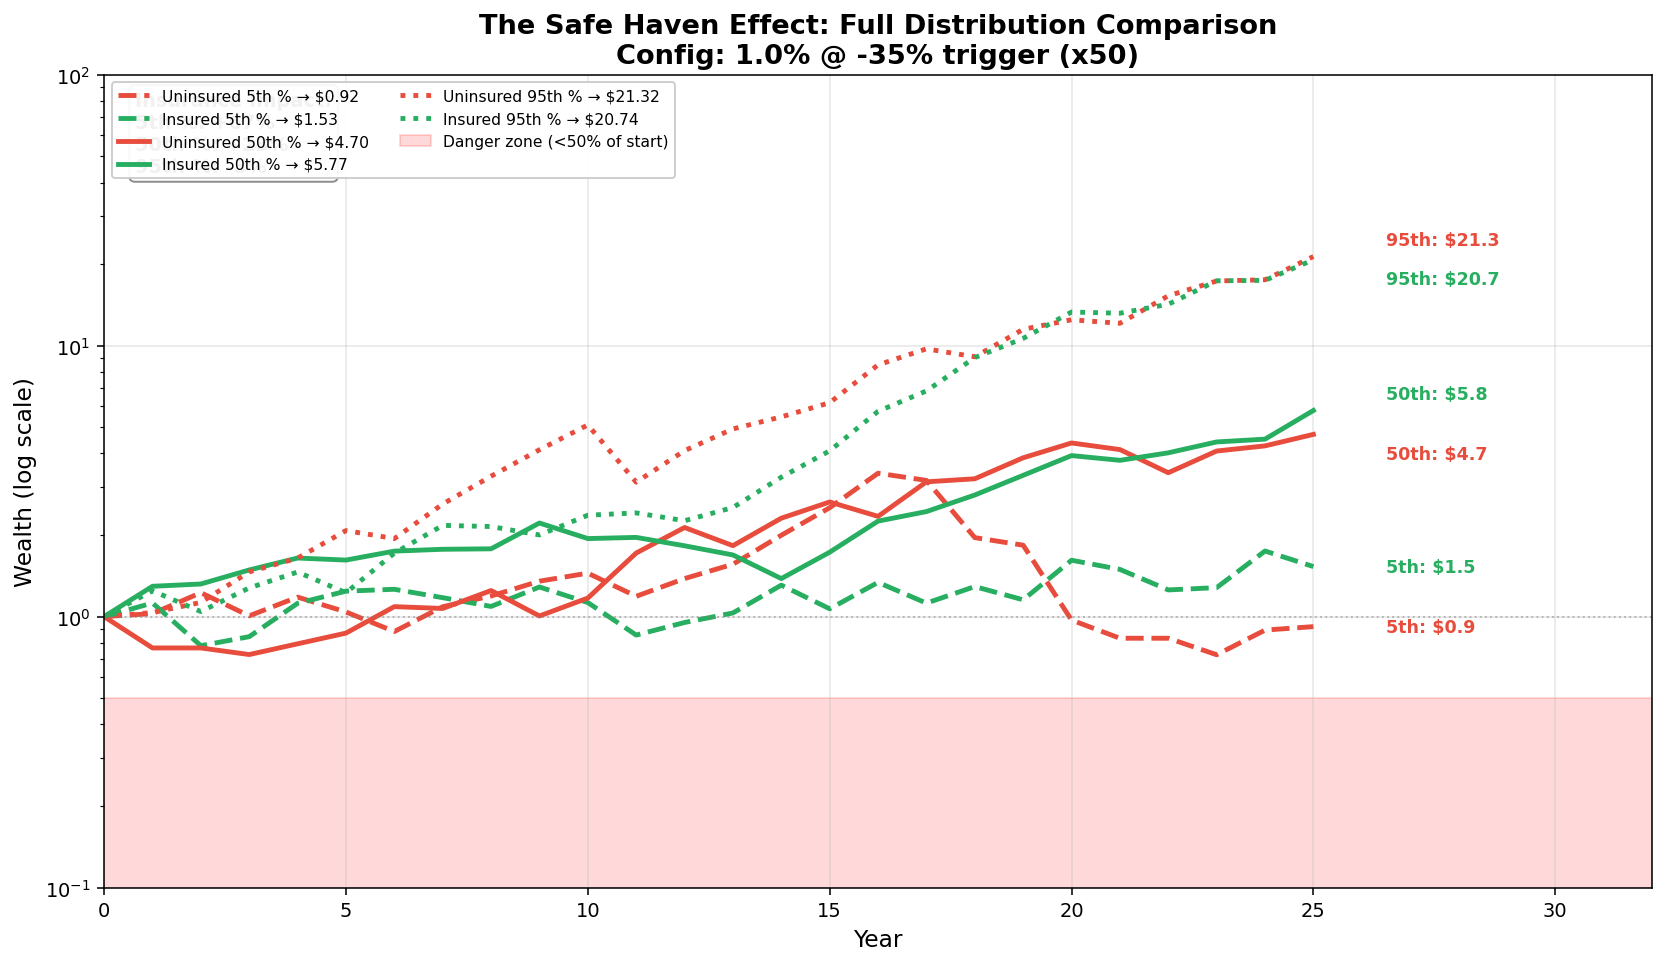

In [52]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# ============================================================================
# PLOT 1: DIRECT OVERLAY COMPARISON (Best configuration vs Uninsured)
# ============================================================================

# Find the best configuration (highest median CAGR improvement at 5th percentile)
best_result = max(results, key=lambda r: r['5th_percentile_cagr'])

#best_result = max(results, key=lambda r: r['50th_percentile_cagr'])
# best_result = max(results, key=lambda r: r['95th_percentile_cagr'])

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Safe Haven Analysis: Insured vs Uninsured Portfolio', 
             fontsize=16, fontweight='bold', y=1.02)

# --- Left: Wealth trajectories overlay ---
ax1 = axes[0]

# Plot uninsured (gray)
for row in wealth_matrix[:2000]:
    ax1.semilogy(row, alpha=0.02, color='#7f8c8d', linewidth=0.5)

# Plot insured (blue)
for row in best_result['wealth_matrix_insured'][:2000]:
    ax1.semilogy(row, alpha=0.02, color='#3498db', linewidth=0.5)

# Percentile lines - Uninsured
ending_wealth = wealth_matrix[:, 25]
percentiles = np.percentile(ending_wealth, [5, 50, 95])
indices = [np.argmin(np.abs(ending_wealth - p)) for p in percentiles]

ax1.semilogy(wealth_matrix[indices[0]], color='#e74c3c', linewidth=2.5, 
             linestyle='--', label='Uninsured 5th %')
ax1.semilogy(wealth_matrix[indices[1]], color='#e74c3c', linewidth=2.5, 
             linestyle='-', label='Uninsured 50th %')

# Percentile lines - Insured
ending_wealth_ins = best_result['wealth_matrix_insured'][:, 25]
percentiles_ins = np.percentile(ending_wealth_ins, [5, 50, 95])
indices_ins = [np.argmin(np.abs(ending_wealth_ins - p)) for p in percentiles_ins]

ax1.semilogy(best_result['wealth_matrix_insured'][indices_ins[0]], 
             color='#27ae60', linewidth=2.5, linestyle='--', label='Insured 5th %')
ax1.semilogy(best_result['wealth_matrix_insured'][indices_ins[1]], 
             color='#27ae60', linewidth=2.5, linestyle='-', label='Insured 50th %')

ax1.set_xlabel('Year', fontsize=11)
ax1.set_ylabel('Wealth (log scale)', fontsize=11)
ax1.set_title(f"Best Config that improves the 5th percentile: {best_result['insurance']*100:.1f}% @ -{(1-best_result['threshold'])*100:.0f}% trigger", 
              fontsize=11)
ax1.set_ylim(0.05, 150)
ax1.legend(loc='upper left', fontsize=8, frameon=True, facecolor='white', framealpha=0.9)
ax1.grid(True, alpha=0.3)

# --- Middle: Percentile band comparison ---
ax2 = axes[1]

# Calculate percentile bands for all years
years_arr = np.arange(years + 1)
unins_5 = np.percentile(wealth_matrix, 5, axis=0)
unins_25 = np.percentile(wealth_matrix, 25, axis=0)
unins_50 = np.percentile(wealth_matrix, 50, axis=0)
unins_75 = np.percentile(wealth_matrix, 75, axis=0)
unins_95 = np.percentile(wealth_matrix, 95, axis=0)

ins_5 = np.percentile(best_result['wealth_matrix_insured'], 5, axis=0)
ins_25 = np.percentile(best_result['wealth_matrix_insured'], 25, axis=0)
ins_50 = np.percentile(best_result['wealth_matrix_insured'], 50, axis=0)
ins_75 = np.percentile(best_result['wealth_matrix_insured'], 75, axis=0)
ins_95 = np.percentile(best_result['wealth_matrix_insured'], 95, axis=0)

# Uninsured bands (red)
ax2.fill_between(years_arr, unins_5, unins_95, alpha=0.15, color='#e74c3c', label='Unins 5-95%')
ax2.fill_between(years_arr, unins_25, unins_75, alpha=0.25, color='#e74c3c', label='Unins 25-75%')
ax2.semilogy(years_arr, unins_50, color='#c0392b', linewidth=2.5, label='Unins median')

# Insured bands (green)
ax2.fill_between(years_arr, ins_5, ins_95, alpha=0.15, color='#27ae60', label='Ins 5-95%')
ax2.fill_between(years_arr, ins_25, ins_75, alpha=0.25, color='#27ae60', label='Ins 25-75%')
ax2.semilogy(years_arr, ins_50, color='#1e8449', linewidth=2.5, label='Ins median')

ax2.set_xlabel('Year', fontsize=11)
ax2.set_ylabel('Wealth (log scale)', fontsize=11)
ax2.set_title('Percentile Bands Comparison', fontsize=11)
ax2.set_ylim(0.05, 150)
ax2.legend(loc='upper left', fontsize=7, frameon=True, facecolor='white', framealpha=0.9, ncol=2)
ax2.grid(True, alpha=0.3)

# --- Right: Final wealth distribution ---
ax3 = axes[2]

# Histogram of ending wealth
bins = np.logspace(np.log10(0.05), np.log10(150), 50)
ax3.hist(ending_wealth, bins=bins, alpha=0.5, color='#e74c3c', label='Uninsured', density=True)
ax3.hist(ending_wealth_ins, bins=bins, alpha=0.5, color='#27ae60', label='Insured', density=True)

# Add vertical lines for medians
ax3.axvline(np.median(ending_wealth), color='#c0392b', linewidth=2, linestyle='--', 
            label=f'Unins median: {np.median(ending_wealth):.1f}')
ax3.axvline(np.median(ending_wealth_ins), color='#1e8449', linewidth=2, linestyle='--',
            label=f'Ins median: {np.median(ending_wealth_ins):.1f}')

ax3.set_xscale('log')
ax3.set_xlabel('Final Wealth (log scale)', fontsize=11)
ax3.set_ylabel('Density', fontsize=11)
ax3.set_title('Final Wealth Distribution (Year 25)', fontsize=11)
ax3.legend(loc='upper right', fontsize=8, frameon=True, facecolor='white', framealpha=0.9)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# PLOT 2: HEATMAP OF ALL CONFIGURATIONS (5th, 50th, 95th percentile)
# ============================================================================

fig2, axes2 = plt.subplots(1, 3, figsize=(15, 5))
fig2.suptitle('Insurance Configuration Performance Heatmap', fontsize=14, fontweight='bold', y=1.02)

# Prepare data for heatmaps
thresh_labels = [f"-{(1-t)*100:.0f}%" for t in thresholds]
ins_labels = [f"{i*100:.1f}%" for i in insurances]

# Create matrices
cagr_5th_matrix = np.zeros((len(thresholds), len(insurances)))
cagr_50th_matrix = np.zeros((len(thresholds), len(insurances)))
cagr_95th_matrix = np.zeros((len(thresholds), len(insurances)))

for result in results:
    i = list(thresholds).index(result['threshold'])
    j = list(insurances).index(result['insurance'])
    cagr_5th_matrix[i, j] = (result['5th_percentile_cagr'] - cagr_5_unins) * 100  # delta in pp
    cagr_50th_matrix[i, j] = (result['50th_percentile_cagr'] - cagr_50_unins) * 100
    cagr_95th_matrix[i, j] = (result['95th_percentile_cagr'] - cagr_95_unins) * 100

# Heatmap 1: 5th percentile CAGR improvement
im1 = axes2[0].imshow(cagr_5th_matrix, cmap='RdYlGn', aspect='auto', 
                       vmin=-2, vmax=2)
axes2[0].set_xticks(range(len(insurances)))
axes2[0].set_xticklabels(ins_labels)
axes2[0].set_yticks(range(len(thresholds)))
axes2[0].set_yticklabels(thresh_labels)
axes2[0].set_xlabel('Insurance Allocation')
axes2[0].set_ylabel('Trigger Threshold')
axes2[0].set_title('5th Percentile CAGR\nImprovement (pp)')
for i in range(len(thresholds)):
    for j in range(len(insurances)):
        axes2[0].text(j, i, f'{cagr_5th_matrix[i,j]:+.2f}', ha='center', va='center', fontsize=8)
plt.colorbar(im1, ax=axes2[0])

# Heatmap 2: 50th percentile CAGR improvement
im2 = axes2[1].imshow(cagr_50th_matrix, cmap='RdYlGn', aspect='auto',
                       vmin=-1, vmax=1)
axes2[1].set_xticks(range(len(insurances)))
axes2[1].set_xticklabels(ins_labels)
axes2[1].set_yticks(range(len(thresholds)))
axes2[1].set_yticklabels(thresh_labels)
axes2[1].set_xlabel('Insurance Allocation')
axes2[1].set_title('50th Percentile CAGR\nImprovement (pp)')
for i in range(len(thresholds)):
    for j in range(len(insurances)):
        axes2[1].text(j, i, f'{cagr_50th_matrix[i,j]:+.2f}', ha='center', va='center', fontsize=8)
plt.colorbar(im2, ax=axes2[1])

# Heatmap 3: 95th percentile CAGR improvement
im3 = axes2[2].imshow(cagr_95th_matrix, cmap='RdYlGn', aspect='auto',
                       vmin=-1, vmax=1)
axes2[2].set_xticks(range(len(insurances)))
axes2[2].set_xticklabels(ins_labels)
axes2[2].set_yticks(range(len(thresholds)))
axes2[2].set_yticklabels(thresh_labels)
axes2[2].set_xlabel('Insurance Allocation')
axes2[2].set_title('95th Percentile CAGR\nImprovement (pp)')
for i in range(len(thresholds)):
    for j in range(len(insurances)):
        axes2[2].text(j, i, f'{cagr_95th_matrix[i,j]:+.2f}', ha='center', va='center', fontsize=8)
plt.colorbar(im3, ax=axes2[2])

plt.tight_layout()
plt.show()

# ============================================================================
# PLOT 3: KEY INSIGHT - The Safe Haven Effect (5th, 50th, 95th percentiles)
# ============================================================================

fig3, ax = plt.subplots(figsize=(12, 7))

# Colors
UNINS_COLOR = '#e74c3c'
INS_COLOR = '#27ae60'

# Plot all three percentile paths for both portfolios
# 5th percentile (worst case)
ax.semilogy(wealth_matrix[indices[0]], color=UNINS_COLOR, linewidth=2.5, linestyle='--',
            label=f'Uninsured 5th % → ${percentiles[0]:.2f}')
ax.semilogy(best_result['wealth_matrix_insured'][indices_ins[0]], color=INS_COLOR, linewidth=2.5, linestyle='--',
            label=f'Insured 5th % → ${percentiles_ins[0]:.2f}')

# 50th percentile (median)
ax.semilogy(wealth_matrix[indices[1]], color=UNINS_COLOR, linewidth=2.5, linestyle='-',
            label=f'Uninsured 50th % → ${percentiles[1]:.2f}')
ax.semilogy(best_result['wealth_matrix_insured'][indices_ins[1]], color=INS_COLOR, linewidth=2.5, linestyle='-',
            label=f'Insured 50th % → ${percentiles_ins[1]:.2f}')

# 95th percentile (best case)
ax.semilogy(wealth_matrix[indices[2]], color=UNINS_COLOR, linewidth=2.5, linestyle=':',
            label=f'Uninsured 95th % → ${percentiles[2]:.2f}')
ax.semilogy(best_result['wealth_matrix_insured'][indices_ins[2]], color=INS_COLOR, linewidth=2.5, linestyle=':',
            label=f'Insured 95th % → ${percentiles_ins[2]:.2f}')

# Add shading for the "ruin zone"
ax.axhspan(0, 0.5, alpha=0.15, color='red', label='Danger zone (<50% of start)')
ax.axhline(y=1, color='gray', linestyle=':', linewidth=1, alpha=0.5)

# Annotations for final values - with offset to avoid overlap
annotations = [
    ('5th', percentiles[0], percentiles_ins[0]),
    ('50th', percentiles[1], percentiles_ins[1]),
    ('95th', percentiles[2], percentiles_ins[2]),
]

for pct_label, pct_u, pct_i in annotations:
    # Calculate vertical offset if values are close (within 30% on log scale)
    ratio = max(pct_u, pct_i) / min(pct_u, pct_i)
    
    if ratio < 1.3:  # Values are close, need offset
        if pct_u > pct_i:
            offset_u, offset_i = 1.15, 0.85  # Push apart
        else:
            offset_u, offset_i = 0.85, 1.15
    else:
        offset_u, offset_i = 1.0, 1.0  # No offset needed
    
    # Uninsured annotation
    ax.annotate(f'{pct_label}: ${pct_u:.1f}', 
                xy=(25, pct_u), xytext=(26.5, pct_u * offset_u),
                fontsize=9, color=UNINS_COLOR, fontweight='bold', va='center')
    # Insured annotation
    ax.annotate(f'{pct_label}: ${pct_i:.1f}', 
                xy=(25, pct_i), xytext=(26.5, pct_i * offset_i),
                fontsize=9, color=INS_COLOR, fontweight='bold', va='center')

# Summary box
improvement_5 = ((percentiles_ins[0] / percentiles[0]) - 1) * 100
improvement_50 = ((percentiles_ins[1] / percentiles[1]) - 1) * 100
improvement_95 = ((percentiles_ins[2] / percentiles[2]) - 1) * 100

summary_text = f"Insurance Impact:\n5th %: {improvement_5:+.0f}%\n50th %: {improvement_50:+.0f}%\n95th %: {improvement_95:+.0f}%"
ax.text(0.02, 0.98, summary_text, transform=ax.transAxes, fontsize=10, fontweight='bold',
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray', alpha=0.9))

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Wealth (log scale)', fontsize=12)
ax.set_title(f"The Safe Haven Effect: Full Distribution Comparison\nConfig: {best_result['insurance']*100:.1f}% @ -{(1-best_result['threshold'])*100:.0f}% trigger (x{best_result['insurance_multiplier_when_threshold_met']})", 
             fontsize=14, fontweight='bold')
ax.set_ylim(0.1, 100)
ax.set_xlim(0, 32)  # Extended to give room for labels
ax.legend(loc='upper left', fontsize=8, frameon=True, facecolor='white', framealpha=0.95, ncol=2)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()